Installation

In [1]:
!pip install tensorflow numpy opencv-python tqdm matplotlib

# Install gdown if not already installed
!pip install gdown

# Download dataset from Google Drive
!gdown --id 1Ay0iVLhwyfGmHSR_8NYApURBvmWHtZEN -O archived.zip

# Extract the ZIP file
!unzip -q archived.zip -d dataset

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Ay0iVLhwyfGmHSR_8NYApURBvmWHtZEN
From (redirected): https://drive.google.com/uc?id=1Ay0iVLhwyfGmHSR_8NYApURBvmWHtZEN&confirm=t&uuid=7e83c539-d609-432b-90bf-2c0a079ea4f4
To: /content/archived.zip
100% 256M/256M [00:01<00:00, 140MB/s]


Load data, convert color image to gray colors
Split to train and valiadation

In [2]:
import tensorflow as tf
import os
import numpy as np
import cv2
from tqdm import tqdm

IMG_SIZE = 128
BATCH_SIZE = 10

def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 127.5) - 1  # Normalize to [-1,1]
    return image

def random_jitter(gray, color):
    gray_resized = tf.image.resize(gray, [143, 143])
    color_resized = tf.image.resize(color, [143, 143])

    offset_height = tf.random.uniform(shape=[], minval=0, maxval=143 - IMG_SIZE + 1, dtype=tf.int32)
    offset_width = tf.random.uniform(shape=[], minval=0, maxval=143 - IMG_SIZE + 1, dtype=tf.int32)

    gray_cropped = tf.image.crop_to_bounding_box(gray_resized, offset_height, offset_width, IMG_SIZE, IMG_SIZE)
    color_cropped = tf.image.crop_to_bounding_box(color_resized, offset_height, offset_width, IMG_SIZE, IMG_SIZE)

    if tf.random.uniform(()) > 0.5:
        gray_cropped = tf.image.flip_left_right(gray_cropped)
        color_cropped = tf.image.flip_left_right(color_cropped)

    return gray_cropped, color_cropped

def preprocess_train(image):
    color_image = load_image(image)
    gray_image = tf.image.rgb_to_grayscale(color_image)
    gray_image, color_image = random_jitter(gray_image, color_image)
    return gray_image, color_image

def preprocess_test(image):
    color_image = load_image(image)
    gray_image = tf.image.rgb_to_grayscale(color_image)
    return gray_image, color_image

def get_file_list(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_list.append(os.path.join(root, file))
    return file_list

dataset_folder = "dataset"

all_files = get_file_list(dataset_folder)

train_size = int(0.8 * len(all_files))
train_files = all_files[:train_size]
val_files = all_files[train_size:]

print("Training images:", len(train_files))
print("Validation images:", len(val_files))

train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_files)
val_dataset = val_dataset.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Training images: 2272
Validation images: 569


In [3]:
from tensorflow.keras import layers

def build_pix2pix_generator(input_shape=(128, 128, 1)):
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=input_shape)

    # Encoder
    e1 = layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer)(inputs)
    e1 = layers.LeakyReLU(0.2)(e1)

    e2 = layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(e1)
    e2 = layers.BatchNormalization()(e2)
    e2 = layers.LeakyReLU(0.2)(e2)

    e3 = layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(e2)
    e3 = layers.BatchNormalization()(e3)
    e3 = layers.LeakyReLU(0.2)(e3)

    e4 = layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(e3)
    e4 = layers.BatchNormalization()(e4)
    e4 = layers.LeakyReLU(0.2)(e4)

    e5 = layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(e4)
    e5 = layers.BatchNormalization()(e5)
    e5 = layers.LeakyReLU(0.2)(e5)

    e6 = layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(e5)
    e6 = layers.BatchNormalization()(e6)
    e6 = layers.LeakyReLU(0.2)(e6)

    e7 = layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(e6)
    e7 = layers.Activation('relu')(e7)

    # Decoder with skip connections
    d1 = layers.Conv2DTranspose(512, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(e7)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Concatenate()([d1, e6])

    d2 = layers.Conv2DTranspose(512, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(d1)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.Concatenate()([d2, e5])

    d3 = layers.Conv2DTranspose(512, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(d2)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Concatenate()([d3, e4])

    d4 = layers.Conv2DTranspose(256, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(d3)
    d4 = layers.BatchNormalization()(d4)
    d4 = layers.Concatenate()([d4, e3])

    d5 = layers.Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(d4)
    d5 = layers.BatchNormalization()(d5)
    d5 = layers.Concatenate()([d5, e2])

    d6 = layers.Conv2DTranspose(64, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(d5)
    d6 = layers.BatchNormalization()(d6)
    d6 = layers.Concatenate()([d6, e1])

    d7 = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer)(d6)
    outputs = layers.Activation('tanh')(d7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

generator = build_pix2pix_generator()
generator.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │          1,088 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 64, 64, 64)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 128)    │        131,072 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 128)    │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 32, 32, 128)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 256)    │        524,288 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 16, 16, 256)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 8, 8, 512)      │      2,097,152 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 8, 8, 512)      │          2,048 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 8, 8, 512)      │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 4, 4, 512)      │      4,194,304 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 4, 4, 512)      │          2,048 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 4, 4, 512)      │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 2, 2, 512)      │      4,194,304 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 2, 2, 512)      │          2,048 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 41,834,819 (159.59 MB)

 Trainable params: 41,827,011 (159.56 MB)

 Non-trainable params: 7,808 (30.50 KB)

In [4]:
def build_discriminator(input_shape=(IMG_SIZE, IMG_SIZE, 1), target_shape=(IMG_SIZE, IMG_SIZE, 3)):
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=input_shape, name='input_image')
    tar = layers.Input(shape=target_shape, name='target_image')

    x = layers.Concatenate()([inp, tar])

    x = layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer)(x)
    outputs = layers.Activation('sigmoid')(x)

    return tf.keras.Model(inputs=[inp, tar], outputs=outputs)

discriminator = build_discriminator()
discriminator.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_image (InputLayer) │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 128, 128, 4)    │              0 │ input_image[0][0],     │
│ (Concatenate)             │                        │                │ target_image[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 64)     │          4,160 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 64, 64, 64)     │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 128)    │        131,072 │ leaky_re_lu_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 32, 32, 128)    │            512 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU) │ (None, 32, 32, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 256)    │        524,288 │ leaky_re_lu_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 16, 16, 256)    │          1,024 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 16, 16, 256)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 16, 16, 512)    │      2,097,152 │ leaky_re_lu_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 16, 16, 512)    │          2,048 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_9 (LeakyReLU) │ (None, 16, 16, 512)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 16, 16, 1)      │          8,193 │ leaky_re_lu_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 16, 16, 1)      │              0 │ conv2d_11[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,768,449 (10.56 MB)

 Trainable params: 2,766,657 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [5]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def generator_loss(disc_generated_output, gen_output, target, LAMBDA=100):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_loss = gan_loss + (LAMBDA * l1_loss)
    return total_loss

def generator_loss_cgan_only(disc_generated_output):
    return loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)


In [6]:
@tf.function
def train_step(input_image, target, use_l1=True, LAMBDA=100):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        if use_l1:
            gen_loss = generator_loss(disc_generated_output, gen_output, target, LAMBDA)
        else:
            gen_loss = generator_loss_cgan_only(disc_generated_output)

        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [30]:
import time

EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    total_gen_loss = 0
    total_disc_loss = 0
    steps = 0

    for gray_batch, color_batch in train_dataset:
        g_loss, d_loss = train_step(gray_batch, color_batch, use_l1=True, LAMBDA=100)
        total_gen_loss += g_loss
        total_disc_loss += d_loss
        steps += 1
        if steps % 100 == 0:
            print(f"Step {steps}: Gen Loss = {g_loss.numpy():.4f}, Disc Loss = {d_loss.numpy():.4f}")

    print(f"Epoch {epoch + 1} completed in {time.time() - start:.2f} sec.")
    print(f"Avg Generator Loss: {(total_gen_loss / steps).numpy():.4f}")
    print(f"Avg Discriminator Loss: {(total_disc_loss / steps).numpy():.4f}")


Epoch 1/5
Step 100: Gen Loss = 15.7385, Disc Loss = 0.0056
Step 200: Gen Loss = 15.8895, Disc Loss = 0.0068
Epoch 1 completed in 40.55 sec.
Avg Generator Loss: 15.9071
Avg Discriminator Loss: 0.0102
Epoch 2/5
Step 100: Gen Loss = 16.9538, Disc Loss = 0.0046
Step 200: Gen Loss = 16.8339, Disc Loss = 0.0100
Epoch 2 completed in 35.81 sec.
Avg Generator Loss: 16.9430
Avg Discriminator Loss: 0.0040
Epoch 3/5
Step 100: Gen Loss = 19.4451, Disc Loss = 0.0018
Step 200: Gen Loss = 14.8879, Disc Loss = 0.0064
Epoch 3 completed in 36.53 sec.
Avg Generator Loss: 17.1943
Avg Discriminator Loss: 0.0037
Epoch 4/5
Step 100: Gen Loss = 17.7817, Disc Loss = 0.0017
Step 200: Gen Loss = 17.9244, Disc Loss = 0.0044
Epoch 4 completed in 35.91 sec.
Avg Generator Loss: 18.0228
Avg Discriminator Loss: 0.0027
Epoch 5/5
Step 100: Gen Loss = 19.8366, Disc Loss = 0.0008
Step 200: Gen Loss = 20.6544, Disc Loss = 0.0005
Epoch 5 completed in 36.35 sec.
Avg Generator Loss: 18.7926
Avg Discriminator Loss: 0.0027


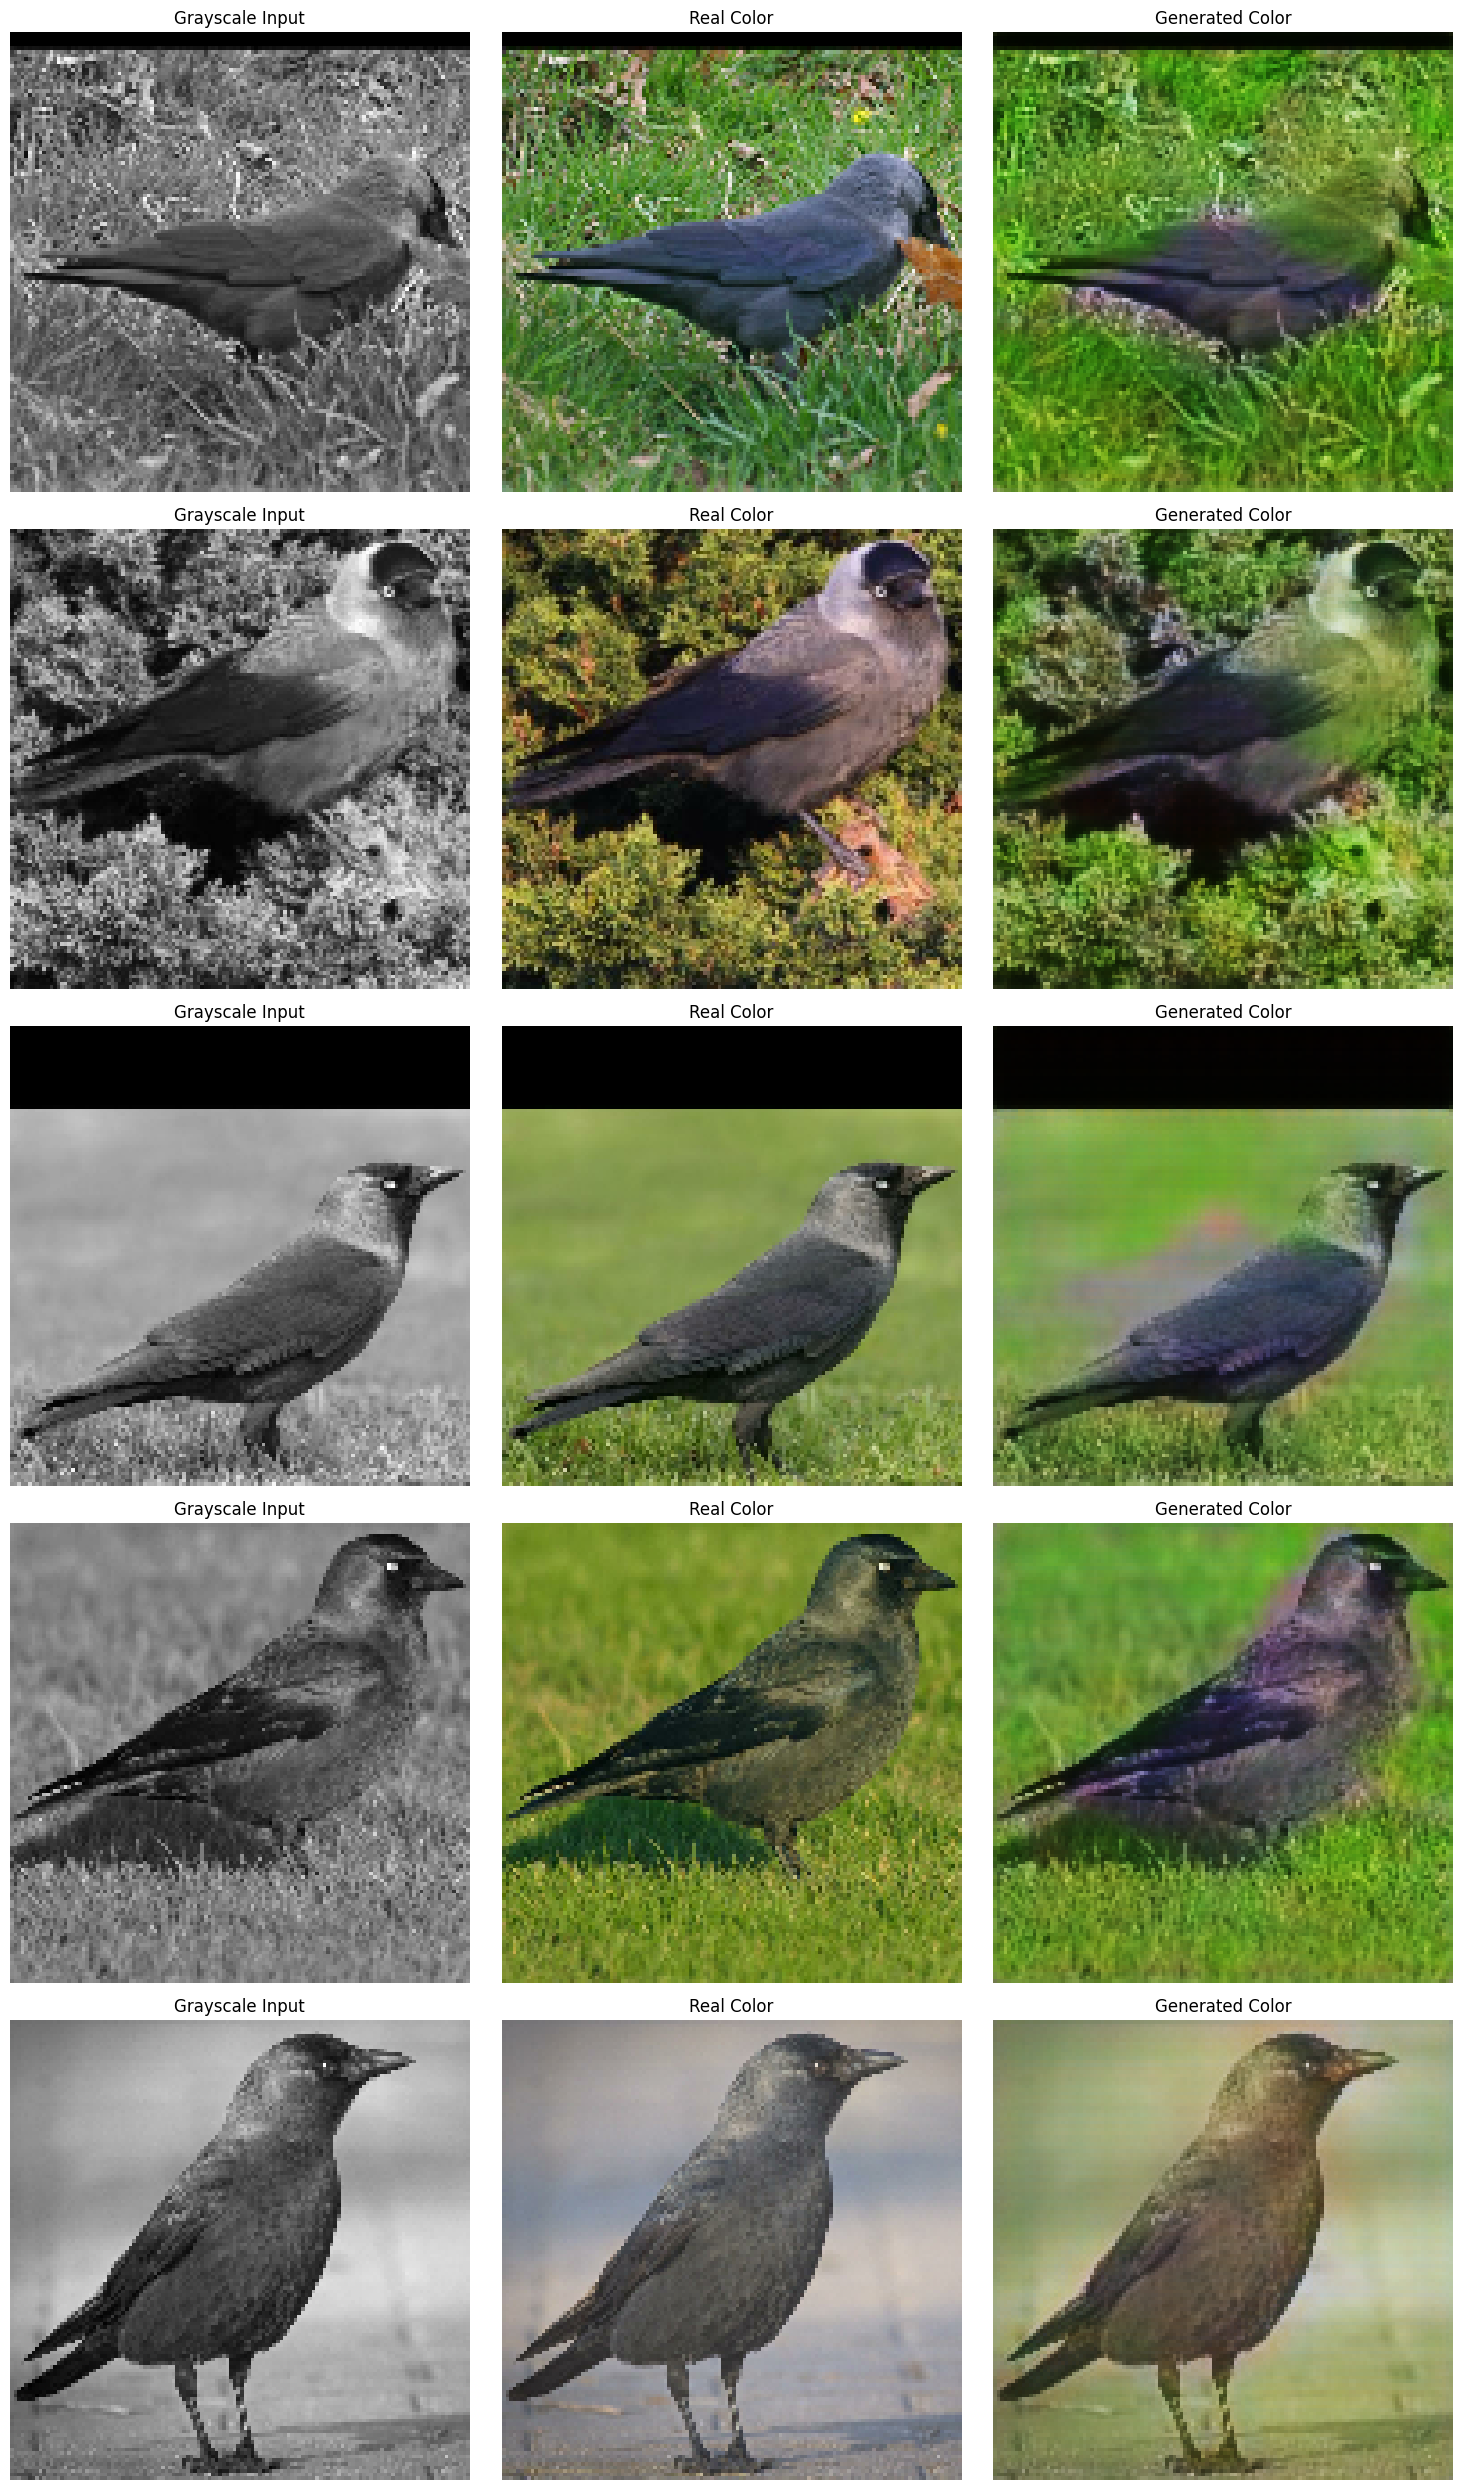

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def generate_with_tta(input_batch):
    output_orig = generator(input_batch, training=False)
    flipped = tf.image.flip_left_right(input_batch)
    output_flipped = generator(flipped, training=False)
    output_flipped = tf.image.flip_left_right(output_flipped)
    return (output_orig + output_flipped) / 2.0


for gray_val, color_val in val_dataset.take(1):
    gen_output = generate_with_tta(gray_val)
    gen_output = (gen_output + 1) / 2.0
    color_val = (color_val + 1) / 2.0
    gray_val_disp = (gray_val + 1) / 2.0

n_examples = 5

plt.figure(figsize=(15, 5 * n_examples))
for i in range(n_examples):
    plt.subplot(n_examples, 3, i * 3 + 1)
    plt.imshow(np.squeeze(gray_val_disp[i]), cmap='gray')
    plt.title("Grayscale Input")
    plt.axis("off")

    plt.subplot(n_examples, 3, i * 3 + 2)
    plt.imshow(color_val[i])
    plt.title("Real Color")
    plt.axis("off")

    plt.subplot(n_examples, 3, i * 3 + 3)
    plt.imshow(gen_output[i])
    plt.title("Generated Color")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [29]:
# Save the trained Generator
generator.save("generator_inference.h5")

print("Generator saved as 'generator_inference.h5'")


Generator saved as 'generator_inference.h5'
